In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import xgboost as xgb
import tensorflow as tf
import math
from scipy.signal import savgol_filter
from keras.models import Sequential
from keras.layers import Reshape, Dense, LSTM, Conv1D, MaxPooling1D, Flatten, TimeDistributed, Input, Attention
from keras.callbacks import EarlyStopping
from pandas.tseries.offsets import DateOffset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

In [59]:
# dirs
DATA_DIR = "./load.csv"
TEST_PLOT_DIR = "./test_plots/residual_hybrid_model/"

In [60]:
if not os.path.exists(TEST_PLOT_DIR):
    os.makedirs(TEST_PLOT_DIR)
if not os.path.exists("./model"):
    os.makedirs("./model")
if not os.path.exists("./training_history"):
    os.makedirs("./training_history")

In [61]:
data = pd.read_csv(DATA_DIR)
data['Timestamp'] = pd.to_datetime(data['Timestamp'], format='%Y/%m/%d %H:%M')

In [62]:
# scaler
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data['Load'].to_numpy().reshape(-1, 1))
data['Load'] = data_scaled

In [63]:
data

,Timestamp,Load
0,2023-01-01 00:00:00,0.445492
1,2023-01-01 00:15:00,0.427049
2,2023-01-01 00:30:00,0.445492
3,2023-01-01 00:45:00,0.420902
4,2023-01-01 01:00:00,0.422951
...,...,...
35035,2023-12-31 22:45:00,0.331148
35036,2023-12-31 23:00:00,0.270492
35037,2023-12-31 23:15:00,0.365574
35038,2023-12-31 23:30:00,0.337295


In [64]:
# Define a function to generate a list of timestamps every 2 hours within the dataset's range
def generate_timestamps(data) -> pd.DatetimeIndex:
    start = data['Timestamp'].min() + DateOffset(days=2)
    end = data['Timestamp'].max() - DateOffset(hours=2, minutes=30)
    timestamps = pd.date_range(start=start, end=end, freq='15min')
    return timestamps


In [65]:
timestamps = generate_timestamps(data)
print(timestamps.shape)

(34838,)


In [66]:
def generate_sets_for_all_timestamps(timestamps, data):
    training_sets = []
    target_sets = []
    training_sets_time = []
    target_sets_time = []

    for timestamp in timestamps:
        # Calculate the range for the current period's data
        start_time_current = timestamp - DateOffset(days=1, hours=23, minutes=45)
        end_time_current = timestamp

        # Calculate the equivalent timestamp for last week
        # timestamp_last_week = timestamp - DateOffset(days=7)
        # start_time_last_week = timestamp_last_week - DateOffset(days=0, hours=23, minutes=45)
        # end_time_last_week = timestamp_last_week

        # Calculate the target range (the next 10 steps after the current timestamp)
        target_start_time = timestamp + DateOffset(minutes=15)
        target_end_time = timestamp + DateOffset(hours=2, minutes=30) 

        # Filter the data for training and target sets
        current_data = data[(data['Timestamp'] >= start_time_current) & (data['Timestamp'] <= end_time_current)]
        # last_week_data = data[(data['Timestamp'] >= start_time_last_week) & (data['Timestamp'] <= end_time_last_week)]
        target_data = data[(data['Timestamp'] >= target_start_time) & (data['Timestamp'] <= target_end_time)]

        # Combine current and last week data for the training set
        training_data = pd.concat([current_data]).reset_index(drop=True)
        
        # Save the training and target sets
        if not training_data.empty and not target_data.empty:
            training_sets.append(training_data['Load'])
            target_sets.append(target_data['Load'])
            training_sets_time.append(list(training_data['Timestamp']))
            target_sets_time.append(list(target_data['Timestamp']))

    return np.array(training_sets), np.array(target_sets), np.array(training_sets_time), np.array(target_sets_time)


In [67]:
# Generate training and target sets for all the timestamps
training_sets, target_sets, training_sets_time, target_sets_time = generate_sets_for_all_timestamps(timestamps, data)

In [68]:
MONTH_TIME_STEP = math.floor(timestamps.shape[0] / 12)
X_test = []
y_test = []
X_test_time = []
y_test_time = []
minList = []
maxList = []
for i in range(0, 12):
    min = (i+1)*MONTH_TIME_STEP-(288*(i+1))
    max = (i+1)*MONTH_TIME_STEP-(288*i)
    X_test.append(training_sets[min:max])
    y_test.append(target_sets[min:max])
    X_test_time.append(training_sets_time[min:max])
    y_test_time.append(target_sets_time[min:max])
    training_sets = np.concatenate([training_sets[:min], training_sets[max:]])
    target_sets = np.concatenate([target_sets[:min], target_sets[max:]])
    training_sets_time = np.concatenate([training_sets_time[:min], training_sets_time[max:]])
    target_sets_time = np.concatenate([target_sets_time[:min], target_sets_time[max:]])


In [69]:
X_test = np.concatenate([i for i in X_test])
y_test = np.concatenate([i for i in y_test])
X_test_time = np.concatenate([i for i in X_test_time])
y_test_time = np.concatenate([i for i in y_test_time])

In [70]:
X_train = training_sets
y_train = target_sets
X_train_time = training_sets_time
y_train_time = target_sets_time

In [71]:
print(np.array(X_train).shape)
print(np.array(X_test).shape)
print(np.array(y_train).shape)
print(np.array(y_test).shape)


(31382, 192)
(3456, 192)
(31382, 10)
(3456, 10)


In [72]:
subsequences = 2
timesteps = X_train.shape[1] // subsequences

X_train_DL = np.array(X_train).reshape(X_train.shape[0], subsequences, timesteps, 1)
X_test_DL = np.array(X_test).reshape(X_test.shape[0], subsequences, timesteps, 1)

In [73]:
X_train_DL.shape

(31382, 2, 96, 1)

In [74]:
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_DL.shape[2], X_train_DL.shape[3])))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(LSTM(25, activation='relu'))
model.add(Dense(32))
model.add(Dense(10))

model.compile(optimizer='adam', loss='mse')
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_9 (TimeDi  (None, None, 96, 64)      128       
 stributed)                                                      
                                                                 
 time_distributed_10 (TimeD  (None, None, 48, 64)      0         
 istributed)                                                     
                                                                 
 time_distributed_11 (TimeD  (None, None, 3072)        0         
 istributed)                                                     
                                                                 
 lstm_8 (LSTM)               (None, None, 50)          624600    
                                                                 
 lstm_9 (LSTM)               (None, 25)                7600      
                                                      

Epoch 1/70
628/628 [==============================] - 8s 11ms/step - loss: 0.0096
Epoch 2/70
628/628 [==============================] - 7s 11ms/step - loss: 0.0050
Epoch 3/70
628/628 [==============================] - 7s 12ms/step - loss: 0.0047
Epoch 4/70
628/628 [==============================] - 7s 11ms/step - loss: 0.0045
Epoch 5/70
628/628 [==============================] - 7s 11ms/step - loss: 0.0044
Epoch 6/70
628/628 [==============================] - 7s 11ms/step - loss: 0.0042
Epoch 7/70
628/628 [==============================] - 7s 11ms/step - loss: 0.0041
Epoch 8/70
628/628 [==============================] - 7s 11ms/step - loss: 0.0040
Epoch 9/70
628/628 [==============================] - 7s 12ms/step - loss: 0.0039
Epoch 10/70
628/628 [==============================] - 7s 11ms/step - loss: 0.0038
Epoch 11/70
628/628 [==============================] - 7s 11ms/step - loss: 0.0037
Epoch 12/70
628/628 [==============================] - 7s 11ms/step - loss: 0.0036
Epoch 13/70
6

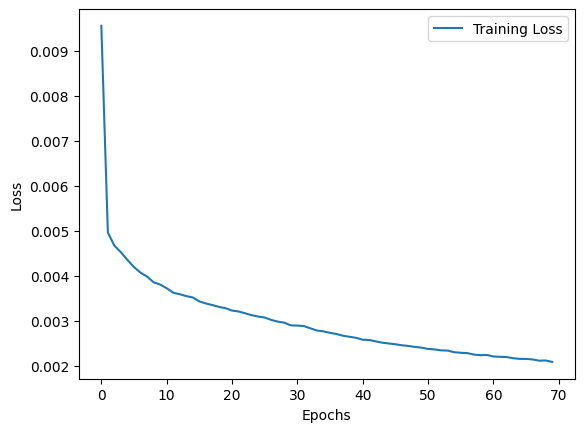

In [75]:
with tf.device("/CPU:0"):
    history = model.fit(
        X_train_DL,
        y_train,
        verbose=1,
        epochs=70,
        batch_size=50,
    )

plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [76]:
y_pred = model.predict(X_test_DL)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print("-" * 86)
print(f'mse: {mse:.4f}')
print(f'mae: {mae:.4f}')
print(f'mape: {mape:.4f}')
print("-" * 86)

108/108 [==============================] - 1s 8ms/step
--------------------------------------------------------------------------------------
mse: 0.0048
mae: 0.0448
mape: 0.1189
--------------------------------------------------------------------------------------


In [77]:
pred_data = scaler.inverse_transform(y_pred)
actual_data = scaler.inverse_transform(y_test)
previous_data = scaler.inverse_transform(X_test)
for i in range(actual_data.shape[0]):
    plt.figure(figsize=(12, 6))
    X1 = np.concatenate((X_test_time[i][-24:], y_test_time[i]))
    y1 = np.concatenate((previous_data[i][-24:], actual_data[i]))
    X2 = y_test_time[i]
    y_p = pred_data[i]
    y_a = actual_data[i]
    Xh = np.full(30, X1[len(X1)-10])
    yh = np.arange(0, 30, 1)
    plt.title(f"Time Series {i+1} prediction")
    plt.plot(X1, y1, '--', color='#98afc7')
    plt.plot(X2, y_p, label='Predict')
    plt.plot(X2, y_a, label='Actual')
    plt.plot(Xh, yh, color='#4863a0', alpha=0.5)
    plt.ylim(0, 30)
    plt.xlabel('Time step')
    plt.ylabel('Usage (kWh)')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.savefig(TEST_PLOT_DIR+f"Filtered_Time_Series_{i+1}.png")
    plt.close()